<a href="https://colab.research.google.com/github/AtsushiNi/myLeprecon/blob/master/niihama/analyze_12-28/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要
スリット幅を300μmから100μmへ変更<br>
プラズマのデータを取った

In [1]:
!pip install git+https://github.com/fujiisoup/pyspectra.git
!pip install lmfit
!pip install netCDF4

  Cloning https://github.com/fujiisoup/pyspectra.git to /tmp/pip-req-build-5behr3_y
  Running command git clone -q https://github.com/fujiisoup/pyspectra.git /tmp/pip-req-build-5behr3_y
  Created wheel for pyspectra: filename=pyspectra-0.0.1-cp36-none-any.whl size=18787 sha256=c3e8fdb6a848e34a55efdfef394b8054f6cbe256a52defee5c403e2ca2a4bae9
  Stored in directory: /tmp/pip-ephem-wheel-cache-sve_f02o/wheels/a7/c4/4a/152e6df7ccc3c6838abee31c086e30a3690c80966eb588e7a2
Successfully built pyspectra


In [2]:
import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate
import pyspectra
import lmfit
from lmfit.models import VoigtModel, ConstantModel, GaussianModel
from lmfit.lineshapes import voigt

In [3]:
data_path = '/content/drive/MyDrive/研究室/myLeprecon/SpectrometerData/20201228_niihama_2'
image_path = '/content/drive/MyDrive/研究室/images/analyze_12-28'
print(os.path.exists(data_path))

True


In [4]:
file_names = [f'H2_{420000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data_array['slit_width'] = data_array.attrs['slit_width']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [5]:
spectrum_data = []
for f in plasma_data:
  min = f.min('x')
  spectrum_data.append(f - min)
spectrum_data = xr.concat(spectrum_data, dim='motor_coordinate')

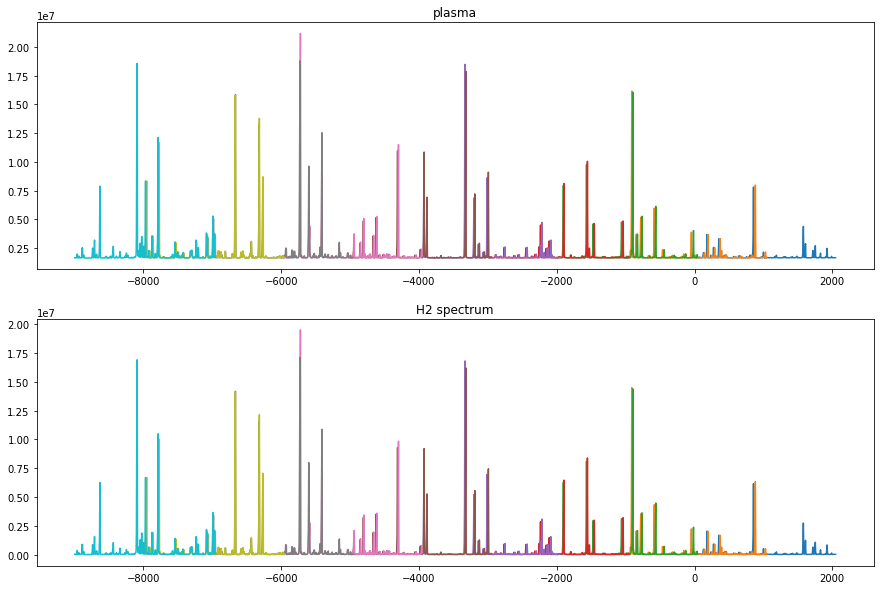

In [6]:
plt.figure(figsize=[15, 10])
plt.subplot(2, 1, 1)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(2, 1, 2)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

# 波長校正

In [7]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

## (v' - v") = (0 - 0)

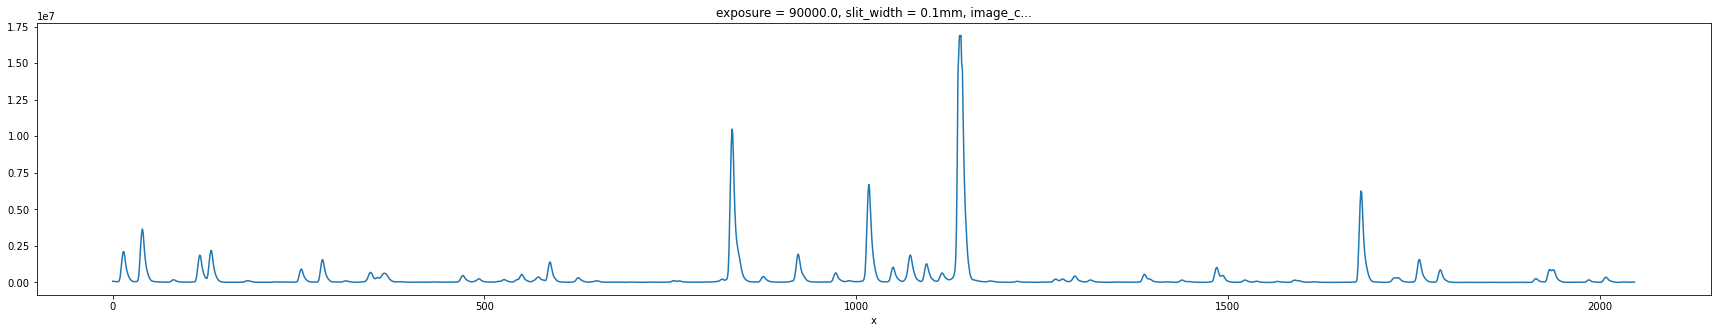

In [8]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()

Text(0, 0.5, 'wave length (nm)')

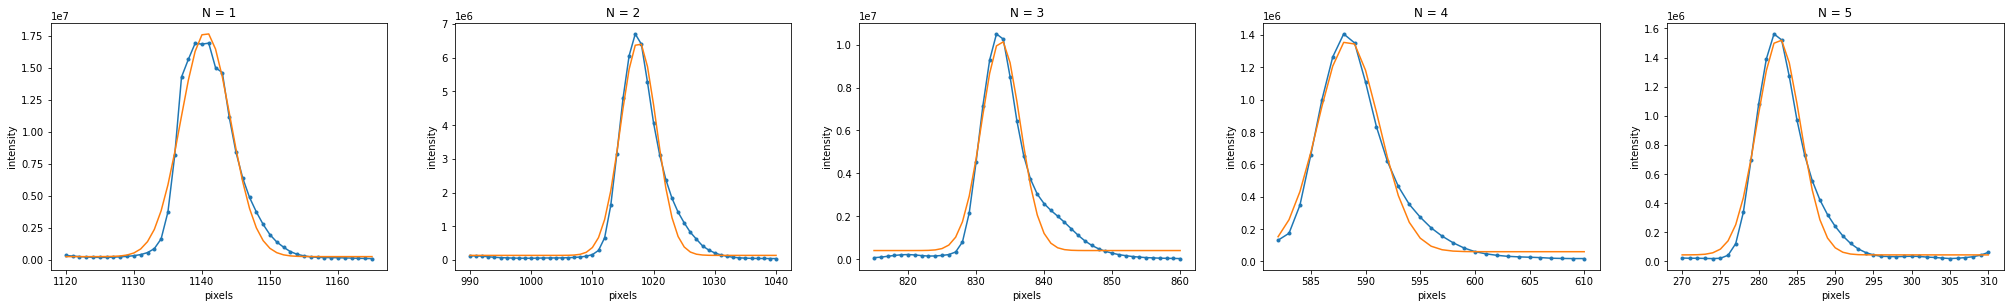

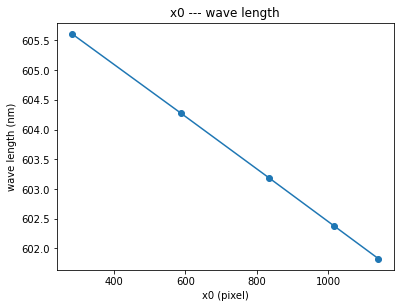

In [9]:
spectrum_lims = [
  [1120, 1165],
  [990, 1040],
  [815, 860],
  [582, 610],
  [270, 310],
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 10))
result_00 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=465000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_00.append(result)
result_00 = xr.concat(result_00, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_00['x0'], result_00['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')


## (v' - v") = (1 - 1)

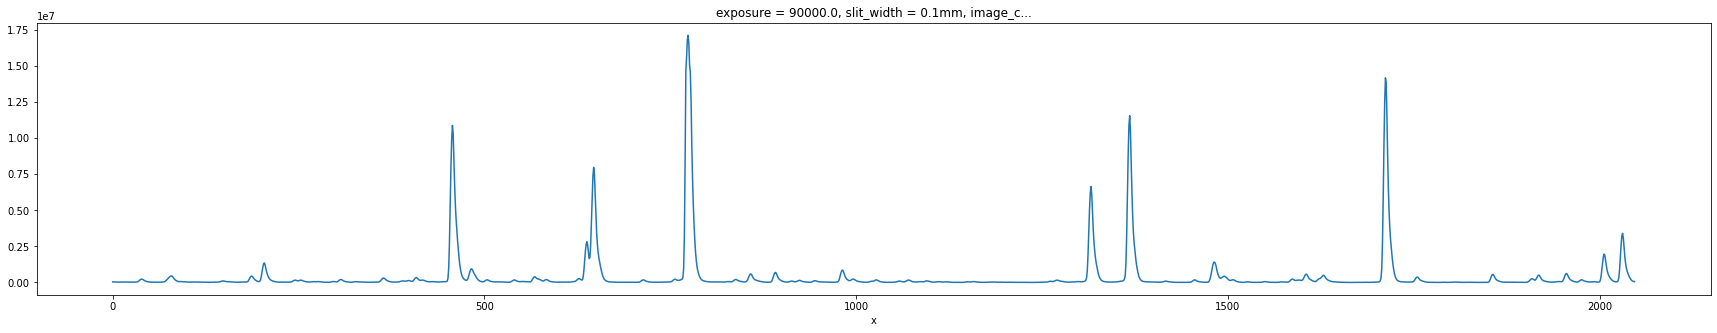

In [10]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=455000).plot()

Text(0, 0.5, 'wave length (nm)')

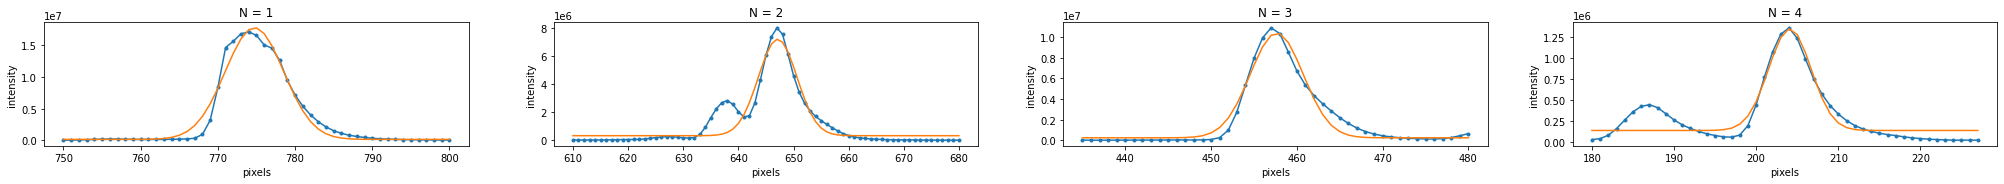

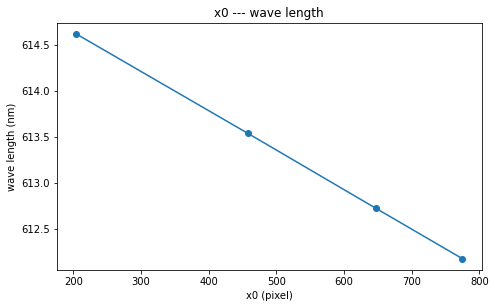

In [11]:
spectrum_lims = [
  [750, 800],
  [610, 680],
  [435, 480],
  [180, 227],
]
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
plt.figure(figsize=(35, 5))
result_11 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=455000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=455000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_11.append(result)
result_11 = xr.concat(result_11, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_11['x0'], result_11['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

## (v' - v") = (2 - 2)

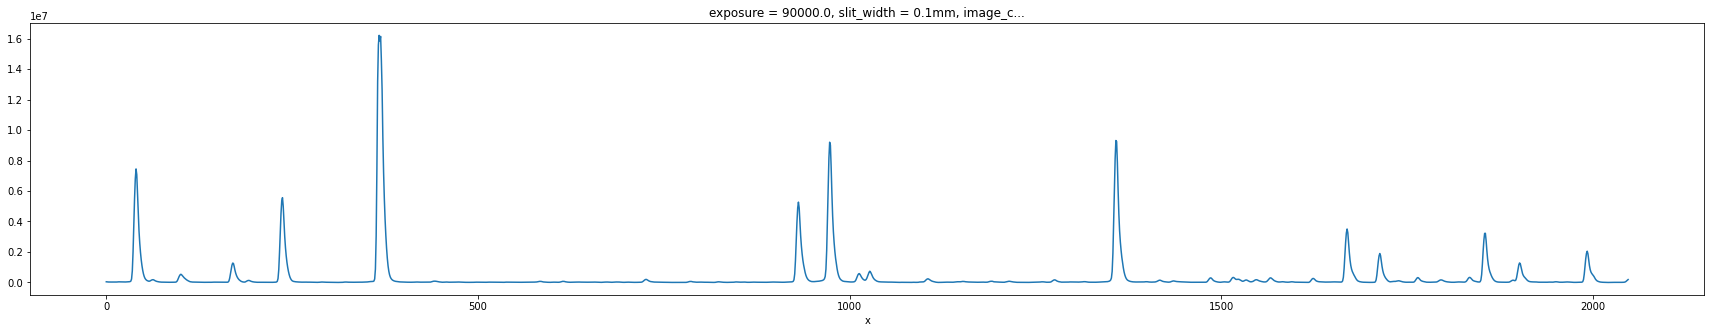

In [12]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=445000).plot()


Text(0, 0.5, 'wave length (nm)')

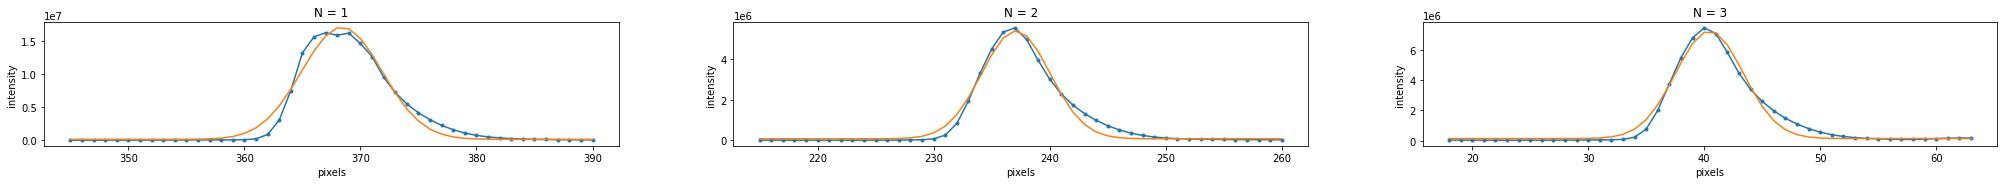

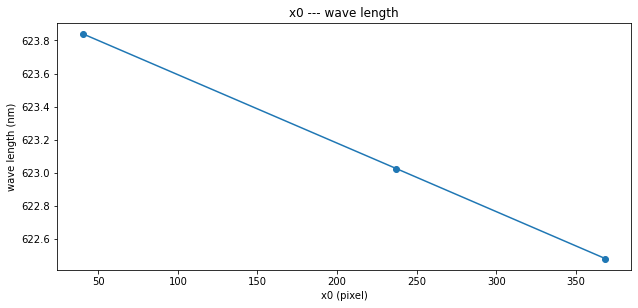

In [13]:
spectrum_lims = [
  [345, 390],
  [215, 260],
  [18, 63],
]
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
  627.8369,
  629.6622,
  631.7233
]
plt.figure(figsize=(35, 5))
result_22 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=445000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=445000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_22.append(result)
result_22 = xr.concat(result_22, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_22['x0'], result_22['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

# ピクセルを波長に変換

Text(0, 0.5, 'wavelength (nm)')

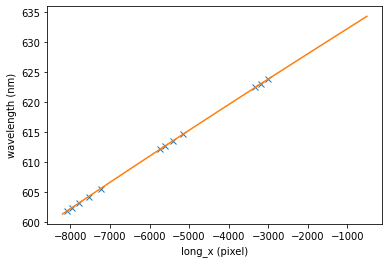

In [14]:
wavelength = np.concatenate([result_00['wave_length'].values, result_11['wave_length'].values, result_22['wave_length'].values])
longx = np.concatenate([result_00['long_x'].values, result_11['long_x'].values, result_22['long_x'].values])

longx_to_wavelength_fun = np.poly1d(np.polyfit(longx, wavelength, 3))
x = np.linspace(-8200, -500, 100)

plt.plot(longx, wavelength, marker='x', linestyle='None')
plt.plot(x, longx_to_wavelength_fun(x))
plt.xlabel('long_x (pixel)')
plt.ylabel('wavelength (nm)')

In [15]:
wavelengths = np.zeros((len(spectrum_data), len(spectrum_data[0])))
for i, a in enumerate(spectrum_data):
  for j, b in enumerate(a):
    wavelengths[i][j] = longx_to_wavelength_fun(int(b['long_x'].values))
print('wavelength')
print(wavelengths)
print('data')
spectrum_data = spectrum_data.values
print(spectrum_data) #データ[motor_coorinate][x]


wavelength
[[644.78390238 644.77981252 644.77572264 ... 636.37263362 636.36849572
  636.36435778]
 [640.68307947 640.67896728 640.67485508 ... 632.22147538 632.21731057
  632.21314573]
 [636.55881274 636.55467599 636.55053922 ... 628.04229395 628.03809999
  628.03390601]
 ...
 [615.5074462  615.50315304 615.49885984 ... 606.64766321 606.64328995
  606.63891664]
 [611.19549118 611.19116002 611.18682882 ... 602.25331722 602.24890138
  602.24448549]
 [606.84441722 606.84004582 606.83567437 ... 597.8152729  597.81081224
  597.80635153]]
data
[[ 21125  18963  18256 ...  57895  57289  64340]
 [ 32976  40076  49189 ...  56955  49449  41673]
 [ 74056  63846  56840 ...  23432  25951  25374]
 ...
 [ 41615  36937  34207 ...  81404  65919  53230]
 [ 45157  39574  35930 ...  86185  88586 113019]
 [ 79268  76442  74227 ...  20853  25415  26145]]


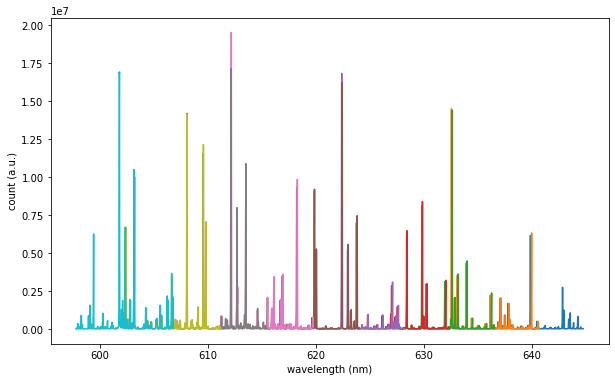

In [16]:
plt.figure(figsize=(10, 6))
plt.xlabel('wavelength (nm)')
plt.ylabel('count (a.u.)')

for i, d in enumerate(spectrum_data):
  plt.plot(wavelengths[i], d)

Text(630.5, 4.1, "N'=8")

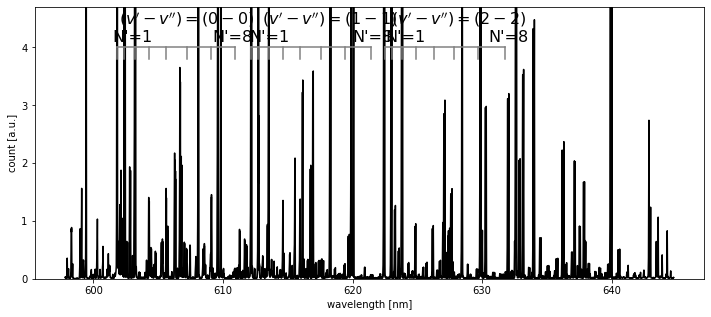

In [17]:
plt.figure(figsize=(12, 5))
plt.xlabel('wavelength [nm]')
plt.ylabel('count [a.u.]')
plt.ylim(0, 4.7)
plt.rcParams['font.size'] = 20

for i, d in enumerate(spectrum_data):
  plt.plot(wavelengths[i], d/1e6, f'k')

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

plt.plot([601.8299, 601.8299], [3.8, 4], color='gray')
plt.plot([602.3757, 602.3757], [3.8, 4], color='gray')
plt.plot([603.1909, 603.1909], [3.8, 4], color='gray')
plt.plot([604.2716, 604.2716], [3.8, 4], color='gray')
plt.plot([605.6091, 605.6091], [3.8, 4], color='gray')
plt.plot([607.1996, 607.1996], [3.8, 4], color='gray')
plt.plot([609.0374, 609.0374], [3.8, 4], color='gray')
plt.plot([610.9030, 610.9030], [3.8, 4], color='gray')
plt.plot([601.8299, 610.9030], [4, 4], color='gray')
plt.text(602, 4.4, "$(v'-v'')=(0-0)$", fontsize=16)
plt.text(601.5, 4.1, "N'=1", fontsize=16)
plt.text(609.2, 4.1, "N'=8", fontsize=16)

plt.plot([612.1787, 612.1787], [3.8, 4], color='gray')
plt.plot([612.7246, 612.7246], [3.8, 4], color='gray')
plt.plot([613.5395, 613.5395], [3.8, 4], color='gray')
plt.plot([614.6186, 614.6186], [3.8, 4], color='gray')
plt.plot([615.9565, 615.9565], [3.8, 4], color='gray')
plt.plot([617.5462, 617.5462], [3.8, 4], color='gray')
plt.plot([619.3812, 619.3812], [3.8, 4], color='gray')
plt.plot([621.4507, 621.4507], [3.8, 4], color='gray')
plt.plot([612.1787, 621.4507], [4, 4], color='gray')
plt.text(613, 4.4, "$(v'-v'')=(1-1)$", fontsize=16)
plt.text(612, 4.1, "N'=1", fontsize=16)
plt.text(620.0, 4.1, "N'=8", fontsize=16)

plt.plot([622.4815, 622.4815], [3.8, 4], color='gray')
plt.plot([623.0258, 623.0258], [3.8, 4], color='gray')
plt.plot([623.8391, 623.8391], [3.8, 4], color='gray')
plt.plot([624.9150, 624.9150], [3.8, 4], color='gray')
plt.plot([626.2495, 626.2495], [3.8, 4], color='gray')
plt.plot([627.8369, 627.8369], [3.8, 4], color='gray')
plt.plot([629.6622, 629.6622], [3.8, 4], color='gray')
plt.plot([631.7233, 631.7233], [3.8, 4], color='gray')
plt.plot([622.4815, 631.7233], [4, 4], color='gray')
plt.text(623, 4.4, "$(v'-v'')=(2-2)$", fontsize=16)
plt.text(622.5, 4.1, "N'=1", fontsize=16)
plt.text(630.5, 4.1, "N'=8", fontsize=16)

#plt.savefig('/content/drive/MyDrive/研究室/images/analyze_12-28/spectrum', bbox_inches='tight')

# フィッティングによる発光強度算出

## (v' - v") = (0 - 0)

{'constant_c': -971299.6390831775, 'voigt_amplitude': 986942.6412508148, 'voigt_center': 601.831286395476, 'voigt_sigma': 0.010888257850446559, 'voigt_gamma': 0.010888257850446559}
{'constant_c': -86126.659855085, 'voigt_amplitude': 262684.1970902429, 'voigt_center': 602.3747604514068, 'voigt_sigma': 0.008114793085759464, 'voigt_gamma': 0.008114793085759464}
{'constant_c': 294509.087826924, 'voigt_amplitude': 373609.6935524129, 'voigt_center': 603.185865043428, 'voigt_sigma': 0.007591638018766833, 'voigt_gamma': 0.007591638018766833}
{'constant_c': 34941.57808525367, 'voigt_amplitude': 50049.016660917645, 'voigt_center': 604.2650938646254, 'voigt_sigma': 0.007570588856733229, 'voigt_gamma': 0.007570588856733229}
{'constant_c': -24772.89398718333, 'voigt_amplitude': 60621.1232854293, 'voigt_center': 605.6074964688169, 'voigt_sigma': 0.00792941768621036, 'voigt_gamma': 0.00792941768621036}
{'constant_c': 36137.35205437377, 'voigt_amplitude': 23875.667727346132, 'voigt_center': 607.180030

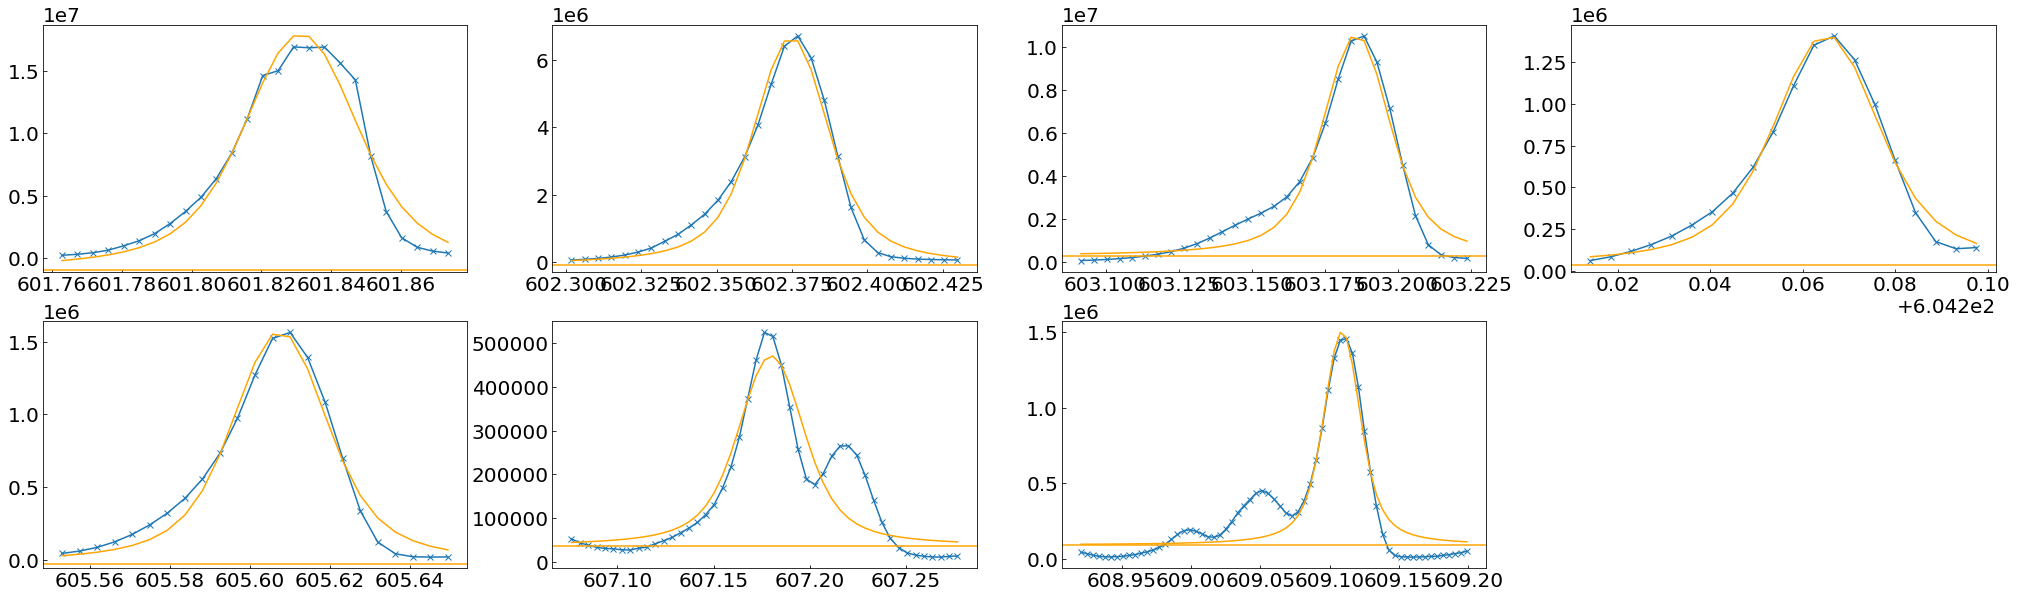

In [18]:
plt.figure(figsize=(35, 10))

args = [
  {"start": 601.76, "end": 601.875, "picture_num": 9},
  {"start": 602.3, "end": 602.43, "picture_num": 9},
  {"start": 603.09, "end": 603.225, "picture_num": 9},
  {"start": 604.21, "end": 604.3, "picture_num": 9},
  {"start": 605.55, "end": 605.65, "picture_num": 9},
  {"start": 607.075, "end": 607.28, "picture_num": 8},
  {"start": 608.92, "end": 609.2, "picture_num": 8},
]

amplitudes_0 = [] # 面積
for i, arg in enumerate(args):
  voigt_model = VoigtModel(prefix='voigt_')
  constant_model = ConstantModel(prefix='constant_')
  range = np.where((arg['start'] < wavelengths[arg['picture_num']]) & (wavelengths[arg['picture_num']] < arg['end']))[0]  
  wavelength = wavelengths[arg['picture_num']][range]
  data = spectrum_data[arg['picture_num']][range]
  params = voigt_model.guess(data, x=wavelength) + constant_model.guess(data, x=wavelength)
  model = voigt_model + constant_model
  result = model.fit(data, params, x = wavelength)
  plt.subplot(2, 4, i+1)
  plt.plot(wavelength, result.data, marker='x')
  plt.plot(wavelength, result.best_fit, color='orange')
  plt.axhline(result.best_values['constant_c'], color='orange')
  amplitudes_0.append(result.best_values['voigt_amplitude'])
  print(result.best_values)

amplitudes_0 = amplitudes_0[0:5]

{'constant_c': 18538.297081560853, 'voigt2_amplitude': 6815.2654348110045, 'voigt2_center': 607.2199144377827, 'voigt2_sigma': 0.006276924034057663, 'voigt2_gamma': 0.006276924034057663, 'voigt1_amplitude': 20383.65079214933, 'voigt1_center': 607.1775781023805, 'voigt1_sigma': 0.008633665795091394, 'voigt1_gamma': 0.008633665795091394}


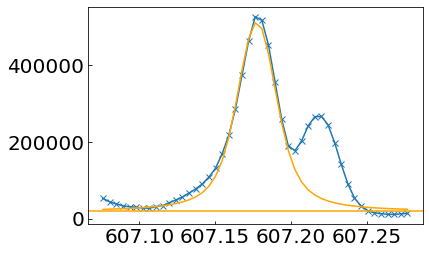

In [19]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + constant_model

range = np.where((607.075 < wavelengths[8]) & (wavelengths[8] < 607.28))[0]  
wavelength = wavelengths[8][range]
data = spectrum_data[8][range]

params = model.make_params()
params_value = {
    'voigt1_amplitude': 20000,
    'voigt1_center': 607.18,
    'voigt1_sigma': 0.011,
    'voigt2_amplitude': 10000,
    'voigt2_center': 607.22,
    'voigt2_sigma': 0.011,
    'constant_c': 0
}
for name in model.param_names:
  params[name].set(value = params_value[name])
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_0.append(result.best_values['voigt1_amplitude'])

{'constant_c': -28608.861311223205, 'voigt2_amplitude': 37786.901514381294, 'voigt2_center': 609.0462726075198, 'voigt2_sigma': 0.022513484770503522, 'voigt2_gamma': 0.022513484770503522, 'voigt1_amplitude': 59645.661105976484, 'voigt1_center': 609.1102076906049, 'voigt1_sigma': 0.008478154357314693, 'voigt1_gamma': 0.008478154357314693}


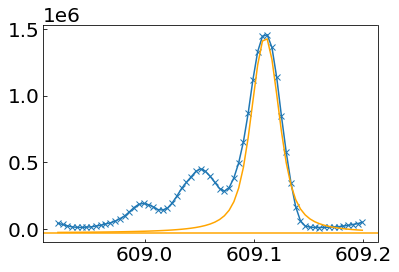

In [20]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + constant_model

range = np.where((608.92 < wavelengths[8]) & (wavelengths[8] < 609.2))[0]  
wavelength = wavelengths[8][range]
data = spectrum_data[8][range]
params = model.make_params()
params_value = {
    'voigt1_amplitude': 60000,
    'voigt1_center': 609.10,
    'voigt1_sigma': 0.0088,
    'voigt2_amplitude': 20000,
    'voigt2_center': 609.05,
    'voigt2_sigma': 0.011,
    'constant_c': 0
}
for name in model.param_names:
  params[name].set(value = params_value[name])
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_0.append(result.best_values['voigt1_amplitude'])

## (v' - v") = (1 - 1)

{'constant_c': -439339.65072234656, 'voigt_amplitude': 961780.8477925162, 'voigt_center': 612.1929299891304, 'voigt_sigma': 0.009582421919872797, 'voigt_gamma': 0.009582421919872797}
{'constant_c': 221778.54814213485, 'voigt_amplitude': 304352.42945068603, 'voigt_center': 612.7345521091374, 'voigt_sigma': 0.008807304823052364, 'voigt_gamma': 0.008807304823052364}
{'constant_c': 112681.8651165325, 'voigt_amplitude': 388820.5606270741, 'voigt_center': 613.5397115146876, 'voigt_sigma': 0.007934363349375584, 'voigt_gamma': 0.007934363349375584}
{'constant_c': 25080.809316995532, 'voigt_amplitude': 45861.584974424084, 'voigt_center': 614.6134849098206, 'voigt_sigma': 0.00798481009865859, 'voigt_gamma': 0.00798481009865859}
{'constant_c': 26893.515219857523, 'voigt_amplitude': 51313.524222862434, 'voigt_center': 615.9517506192844, 'voigt_sigma': 0.008012160056882545, 'voigt_gamma': 0.008012160056882545}


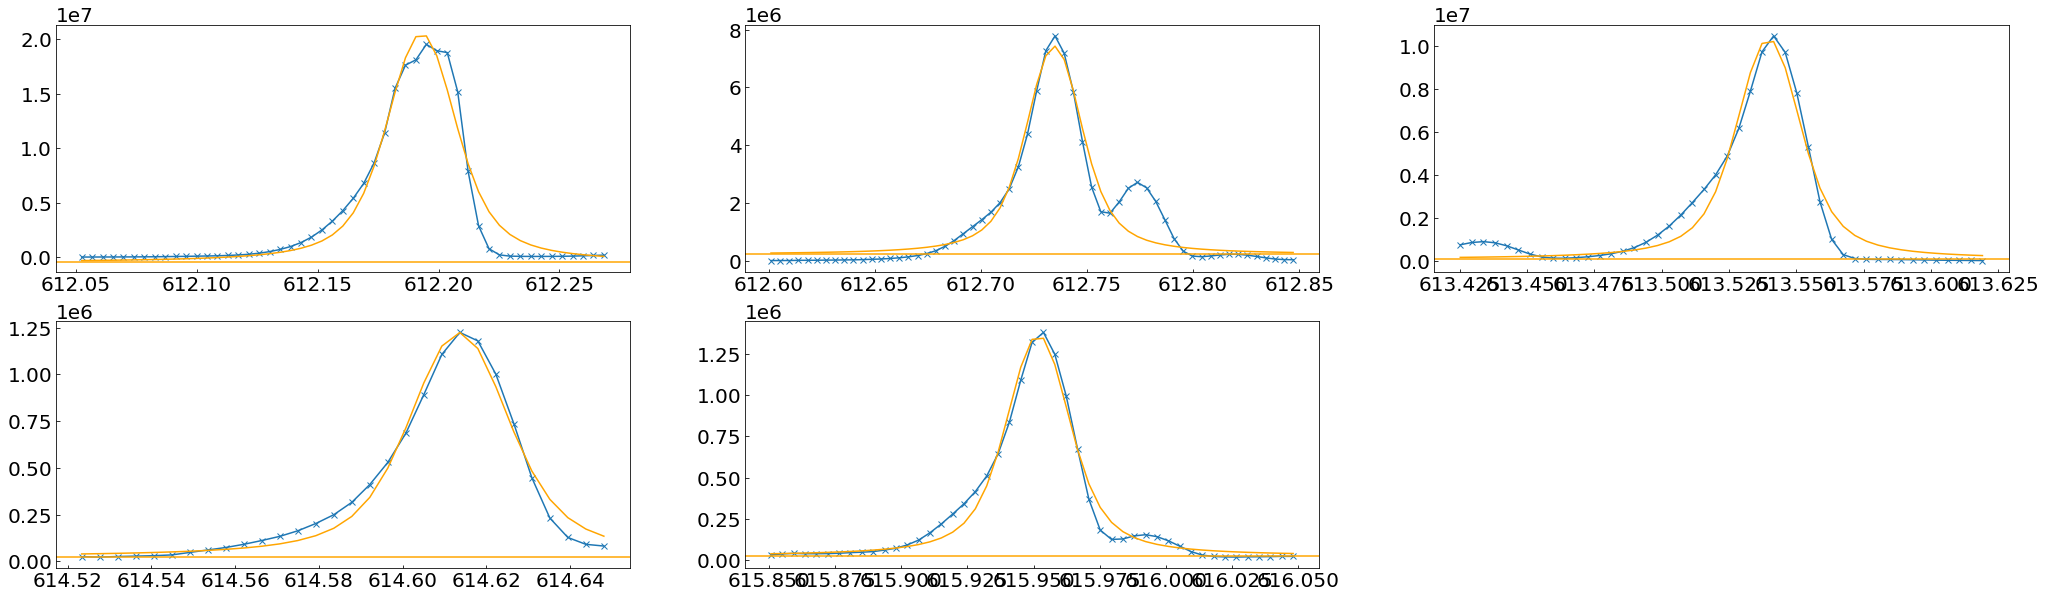

In [21]:
plt.figure(figsize=(35, 10))

args = [
  {"start": 612.05, "end": 612.27, "picture_num": 6},
  {"start": 612.6, "end": 612.85, "picture_num": 6},
  {"start": 613.425, "end": 613.62, "picture_num": 6},
  {"start": 614.52, "end": 614.65, "picture_num": 6},
  {"start": 615.85, "end": 616.05, "picture_num": 6},
]

amplitudes_1 = [] # 面積
for i, arg in enumerate(args):
  voigt_model = VoigtModel(prefix='voigt_')
  constant_model = ConstantModel(prefix='constant_')
  range = np.where((arg['start'] < wavelengths[arg['picture_num']]) & (wavelengths[arg['picture_num']] < arg['end']))[0]  
  wavelength = wavelengths[arg['picture_num']][range]
  data = spectrum_data[arg['picture_num']][range]
  params = voigt_model.guess(data, x=wavelength) + constant_model.guess(data, x=wavelength)
  model = voigt_model + constant_model
  result = model.fit(data, params, x = wavelength)
  plt.subplot(2, 3, i+1)
  plt.plot(wavelength, result.data, marker='x')
  plt.plot(wavelength, result.best_fit, color='orange')
  plt.axhline(result.best_values['constant_c'], color='orange')
  amplitudes_1.append(result.best_values['voigt_amplitude'])
  print(result.best_values)

amplitudes_1[1] = 0
amplitudes_1[4] = 0

{'constant_c': 36861.43751615883, 'voigt2_amplitude': 55669.68201210481, 'voigt2_center': 612.7758573030706, 'voigt2_sigma': 0.005047554482920491, 'voigt2_gamma': 0.005047554482920491, 'voigt1_amplitude': 295318.43712754594, 'voigt1_center': 612.7339410307295, 'voigt1_sigma': 0.008170027763385601, 'voigt1_gamma': 0.008170027763385601}


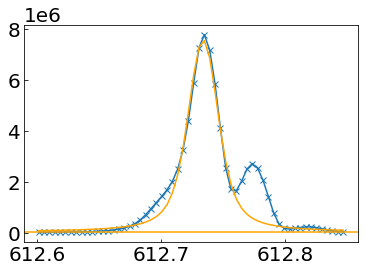

In [22]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + constant_model

range = np.where((612.6 < wavelengths[6]) & (wavelengths[6] < 612.85))[0]  
wavelength = wavelengths[6][range]
data = spectrum_data[6][range]
params = model.make_params()
params_value = {
    'voigt1_amplitude': 300000,
    'voigt1_center': 612.73,
    'voigt1_sigma': 0.0088,
    'voigt2_amplitude': 80000,
    'voigt2_center': 612.77,
    'voigt2_sigma': 0.011,
    'constant_c': 0
}
for name in model.param_names:
  params[name].set(value = params_value[name])
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_1[1] = result.best_values['voigt1_amplitude']

{'constant_c': -3998.70978988465, 'voigt2_amplitude': 7000, 'voigt2_center': 615.99, 'voigt2_sigma': 0.00813, 'voigt2_gamma': 0.00813, 'voigt1_amplitude': 50877.964696930685, 'voigt1_center': 615.9512737529936, 'voigt1_sigma': 0.007787468119351271, 'voigt1_gamma': 0.007787468119351271}


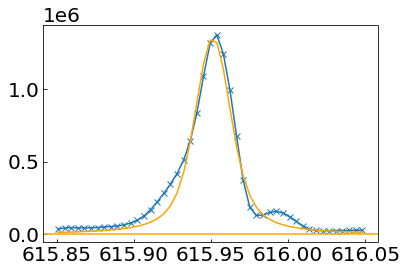

In [23]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + constant_model

range = np.where((615.85 < wavelengths[6]) & (wavelengths[6] < 616.05))[0]  
wavelength = wavelengths[6][range]
data = spectrum_data[6][range]
params = model.make_params()
params_value = {
    'voigt1_amplitude': 51300,
    'voigt1_center': 615.95,
    'voigt1_sigma': 0.0080,
    'voigt2_amplitude': 7000,
    'voigt2_center': 615.99,
    'voigt2_sigma': 0.00813,
    'constant_c': 0
}
for name in model.param_names:
  params[name].set(value = params_value[name])
params['voigt2_center'].set(value=615.99, vary=False)
params['voigt2_sigma'].set(value=0.00813, vary=False)
params['voigt2_amplitude'].set(value=7000, vary=False)
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
voigt2 = voigt(wavelength, result.best_values['voigt2_amplitude'], result.best_values['voigt2_center'], result.best_values['voigt2_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_1[4] = result.best_values['voigt1_amplitude']

## (v' - v") = (2 - 2)

{'constant_c': -465384.3650117181, 'voigt_amplitude': 789567.902078241, 'voigt_center': 622.4180176180778, 'voigt_sigma': 0.009101686075013049, 'voigt_gamma': 0.009101686075013049}
{'constant_c': -60429.23848933978, 'voigt_amplitude': 198768.684822434, 'voigt_center': 622.9645856097168, 'voigt_sigma': 0.007940412831274557, 'voigt_gamma': 0.007940412831274557}
{'constant_c': -46286.91164144659, 'voigt_amplitude': 262542.13032353343, 'voigt_center': 623.7821989355277, 'voigt_sigma': 0.007789258153159118, 'voigt_gamma': 0.007789258153159118}
{'constant_c': 4269.900265854235, 'voigt_amplitude': 34736.28705766386, 'voigt_center': 624.8706797324775, 'voigt_sigma': 0.007627760420958474, 'voigt_gamma': 0.007627760420958474}
{'constant_c': 12457.87139294391, 'voigt_amplitude': 33384.54290110476, 'voigt_center': 626.2279941286496, 'voigt_sigma': 0.007592181533165432, 'voigt_gamma': 0.007592181533165432}


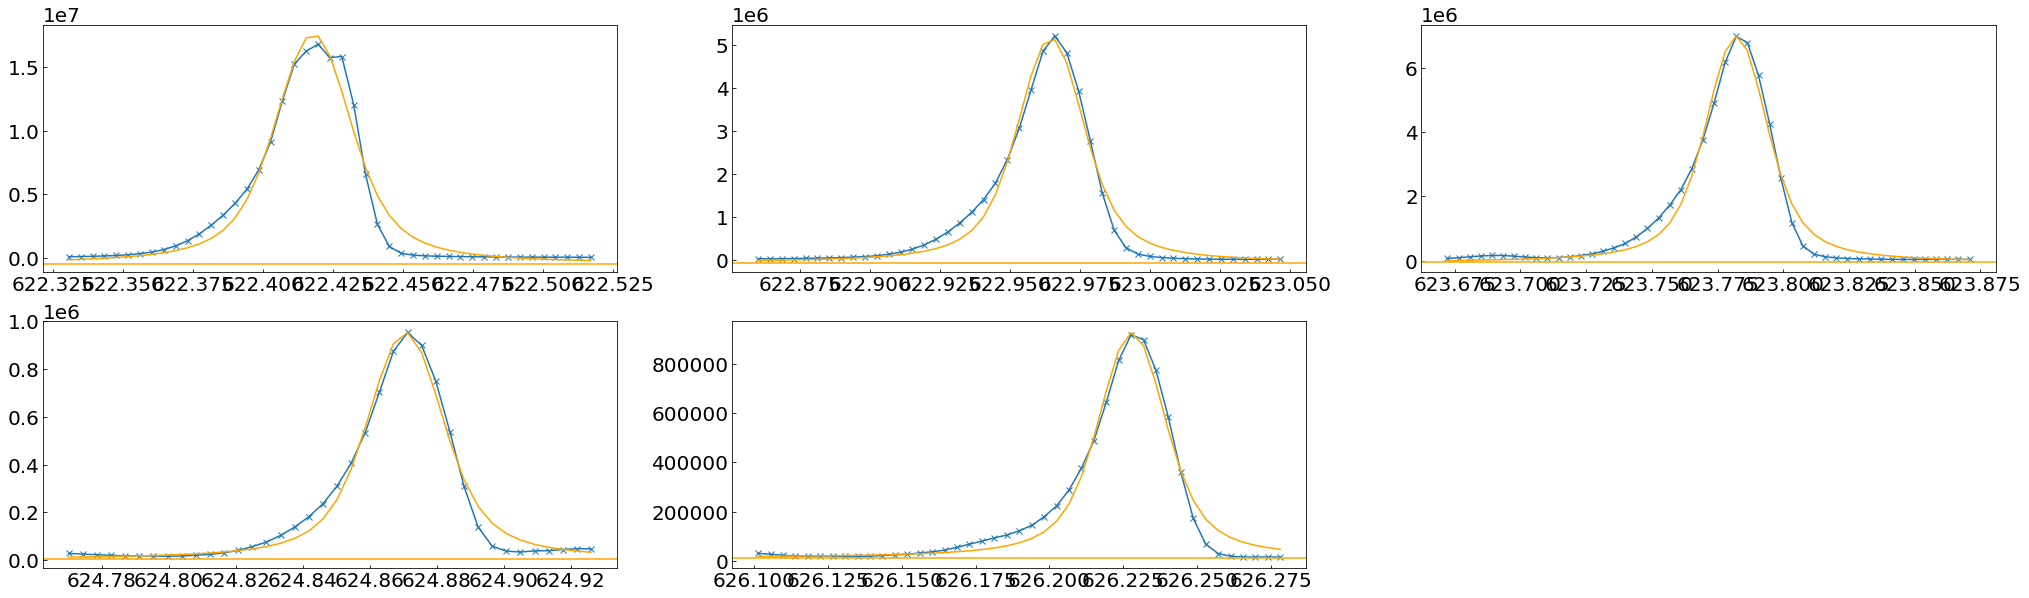

In [24]:
plt.figure(figsize=(35, 10))

args = [
  {"start": 622.33, "end": 622.52, "picture_num": 4},
  {"start": 622.86, "end": 623.05, "picture_num": 4},
  {"start": 623.67, "end": 623.875, "picture_num": 4},
  {"start": 624.77, "end": 624.93, "picture_num": 4},
  {"start": 626.1, "end": 626.28, "picture_num": 4},
]

amplitudes_2 = [] # 面積
for i, arg in enumerate(args):
  voigt_model = VoigtModel(prefix='voigt_')
  constant_model = ConstantModel(prefix='constant_')
  range = np.where((arg['start'] < wavelengths[arg['picture_num']]) & (wavelengths[arg['picture_num']] < arg['end']))[0]  
  wavelength = wavelengths[arg['picture_num']][range]
  data = spectrum_data[arg['picture_num']][range]
  params = voigt_model.guess(data, x=wavelength) + constant_model.guess(data, x=wavelength)
  model = voigt_model + constant_model
  result = model.fit(data, params, x = wavelength)
  plt.subplot(2, 3, i+1)
  plt.plot(wavelength, result.data, marker='x')
  plt.plot(wavelength, result.best_fit, color='orange')
  plt.axhline(result.best_values['constant_c'], color='orange')
  amplitudes_2.append(result.best_values['voigt_amplitude'])
  print(result.best_values)


In [25]:
print(amplitudes_0)
print(amplitudes_1)
print(amplitudes_2)

[986942.6412508148, 262684.1970902429, 373609.6935524129, 50049.016660917645, 60621.1232854293, 20383.65079214933, 59645.661105976484]
[961780.8477925162, 295318.43712754594, 388820.5606270741, 45861.584974424084, 50877.964696930685]
[789567.902078241, 198768.684822434, 262542.13032353343, 34736.28705766386, 33384.54290110476]


# ファイルに保存

In [26]:
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
]
array_0 = xr.DataArray(amplitudes_0, dims=['dN'], coords=[('dN', np.arange(1, 8))])
array_0 = array_0.assign_coords(wavelength=('dN', wave_lengths))
array_0 = array_0.assign_coords(intensity=('dN', amplitudes_0))

wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
array_1 = xr.DataArray(amplitudes_1, dims=['dN'], coords=[('dN', np.arange(1, 6))])
array_1 = array_1.assign_coords(wavelength=('dN', wave_lengths))
array_1 = array_1.assign_coords(intensity=('dN', amplitudes_1))

wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
]
array_2 = xr.DataArray(amplitudes_2, dims=['dN'], coords=[('dN', np.arange(1, 6))])
array_2 = array_2.assign_coords(wavelength=('dN', wave_lengths))
array_2 = array_2.assign_coords(intensity=('dN', amplitudes_2))


In [29]:
array_0.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-28/array_0.nc'))
array_1.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-28/array_1.nc'))
array_2.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-28/array_2.nc'))


In [28]:
xr.load_dataarray('/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-28/array_0.nc')

<xarray.DataArray (dN: 7)>
array([986942.64125081, 262684.19709024, 373609.69355241,  50049.01666092,
        60621.12328543,  20383.65079215,  59645.66110598])
Coordinates:
  * dN          (dN) int64 1 2 3 4 5 6 7
    wavelength  (dN) float64 601.8 602.4 603.2 604.3 605.6 607.2 609.0
    intensity   (dN) float64 9.869e+05 2.627e+05 ... 2.038e+04 5.965e+04